---

TODO - adjust the logos, maybe just use ESA, Copernicus, and ESA climate offuce

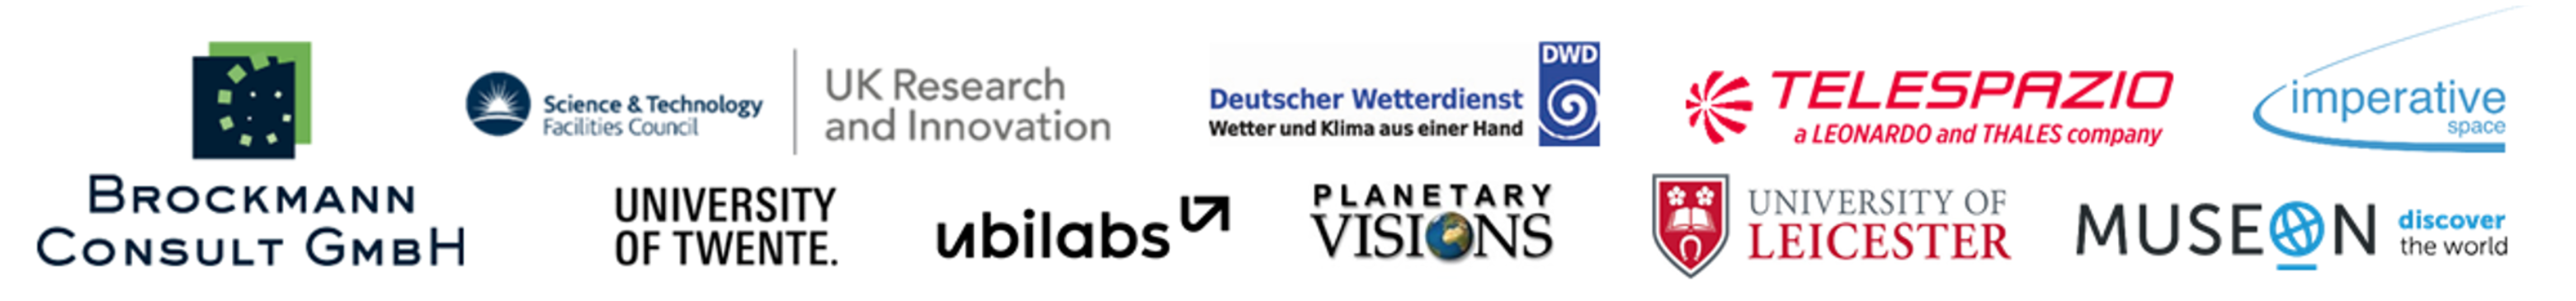

# Value-Adding to the Pixel - the ESA Climate Change Initiative (CCI)

TODO - some intro text about CCI and its ECVs

## The pixel arrives in CCI's Open Data Portal (ODP)

TODO - some more text about ODP

In [19]:
import json
import os.path
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from xcube.core.store import new_data_store
from xcube.core.geom import rasterize_features
from xcube.core.geom import mask_dataset_by_geometry
from xcube.core.resampling.affine import affine_transform_dataset
from xcube.core.gridmapping import GridMapping

In [ ]:
from cate.util.im.cmap_lc import register_lc_color_map
register_lc_color_map()

In [42]:
def cache_dataset(ds, path, off=False, force=False):
    if off:
        return ds
    if force or not os.path.exists(path):
        ds.to_zarr(path, mode="w")
    return xr.open_zarr(path) 

def time_to_year(ds):
    years = [pd.Timestamp(t.values).year for t in ds.time]
    return ds.assign_coords(time=xr.DataArray(years, dims='time'))

---
### Inspect CCI-Toolbox' Zarr Store (high performance data access)

_We connect to the ESA CCI Open Data Portal (ODP). It contains a large number of Essential Climate Variables (ECVs).  
We open the so-called zarr-store within the ODP which contains most relevant ECVs in a very fast access mode.  
The content of the data store is listed to show which ECVs are included._

In [3]:
store = new_data_store('ccizarr')

In [4]:
list(store.get_data_ids())

['BICEP-OC-L3S-PP-MERGED-1M_MONTHLY_9km_mapped-1998-2020-fv4.2.zarr',
 'ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-2018-fv2.0.zarr',
 'ESACCI-GHG-L2-CH4-SCIAMACHY-WFMD-2002-2011-fv1.zarr',
 'ESACCI-GHG-L2-CO2-SCIAMACHY-WFMD-2002-2012-fv1.zarr',
 'ESACCI-ICESHEETS_Antarctica_GMB-2002-2016-v1.1.zarr',
 'ESACCI-ICESHEETS_Greenland_GMB-2003-2016-v1.1.zarr',
 'ESACCI-L3C_CLOUD-CLD_PRODUCTS-AVHRR_NOAA-1982-2016-fv3.0.zarr',
 'ESACCI-L3C_SNOW-SWE-1979-2018-fv1.0.zarr',
 'ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.zarr',
 'ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
 'ESACCI-OC-L3S-IOP-MERGED-1M_MONTHLY_4km_GEO_PML_OCx_QAA-1997-2020-fv5.0.zarr',
 'ESACCI-PERMAFROST-L4-ALT-MODISLST-AREA4_PP-1997-2018-fv02.0.zarr',
 'ESACCI-SEAICE-L3C-SITHICK-RA2_ENVISAT-NH25KMEASE2-2002-2012-fv2.0.zarr',
 'ESACCI-SEAICE-L3C-SITHICK-RA2_ENVISAT-NH25KMEASE2-2002-2012-fv2_4326.zarr',
 'ESACCI-SEAICE-L3C-SITHICK-RA2_ENVISAT-NH25KMEASE2-2002-2012-fv2_repro.zarr',
 'ESACCI-SEAICE-L3C-SITHICK

---
### Open Soil Moisture ECV

_Our interest is with Soil Moisture. The ECV dataset of the ODP contains a large number of variables. Our interest is the the volumetric soil moisture and its uncertainty.  
In order to save memory and time we drop those variables we are not interested in.  
The "sm_datatest" can be inspected. It has global coverage with 0.25° spacing, resulting in 720 grid cells in latitude and 1440 in longitude.  
It has daily temporal resolution and covers 43 years, from 01. November 1978 until 31.12.2020. It is a multi-mission synthesis, as can be seen from the meta data._

In [5]:
drop_variables = ['t0', 'freqbandID', 'sensor', 'mode', 'dnflag', 'flag']  # Not needed; we do not load them to save time and memory
sm_dataset = store.open_data('ESACCI-SOILMOISTURE-L3S-SSMV-COMBINED-1978-2020-fv05.3.zarr', 
                             drop_variables=drop_variables)
sm_dataset

<xarray.Dataset>
Dimensions:         (lat: 720, lon: 1440, time: 15402)
Coordinates:
  * lat             (lat) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
  * lon             (lon) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time            (time) datetime64[ns] 1978-11-01 1978-11-02 ... 2020-12-31
Data variables:
    sm              (time, lat, lon) float32 dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(16, 720, 720), meta=np.ndarray>
Attributes: (12/40)
    Conventions:                CF-1.7
    cdm_data_type:              Grid
    comment:                    This dataset was produced with funding of the...
    contact:                    cci_sm_contact@eodc.eu
    creator_email:              cci_sm_contact@eodc.eu
    creator_name:               Department of Geodesy and Geoinformation, Tec...
    ...                         ...
    time_coverage_duration:     P42Y
    time_coverage_end:          2020-12-31 00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1978-11-01 00:00:00
    title:                      ESA CCI Surface Soil Moisture COMBINED active...
    tracking_id:                174f51a4-6a06-4352-a712-4d3f77bd8166

_We look at the global distribution of soil moisture on the first day in the dataset and compare it to the one 43 days laters.  
While the data from 1978 are from a single instrument (Nimbus 7) and thus the single overpasses can be clearly seen, in 2020  
there were several satellites contributing to the dataset and we get a fairly good global coverage every day. The Scientists working  
on the algorithm within the ESA CCI programme have paid a lot of attention to harmonise the various input data in order to get a consistent  
long term time series._

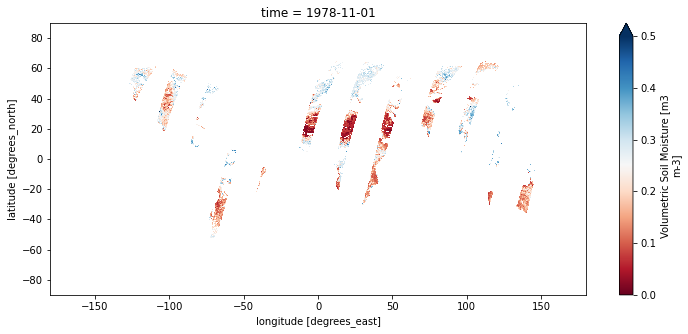

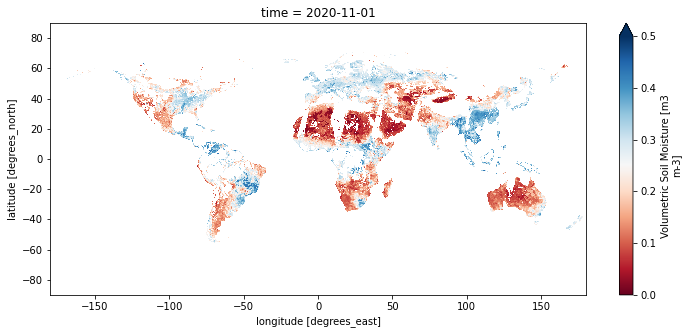

In [6]:
sm_dataset.sel(time="1978-11-01").sm.plot.imshow(cmap='RdBu', vmin = 0, vmax =0.5, figsize=(12, 5))
sm_dataset.sel(time="2020-11-01").sm.plot.imshow(cmap='RdBu', vmin = 0, vmax =0.5, figsize=(12, 5))

_Climate data require uncertainties to unleash their full potential. All CCI datasets are delivered with uncertainties where this is  
possible. Thanks to the multiple observations from different satellites this is possible for the later soil moisture data. The uncertainties  
are one order of magnitude smaller than the soil moisture observations in wet areas but are larger in the dry areas (compare the scale)_

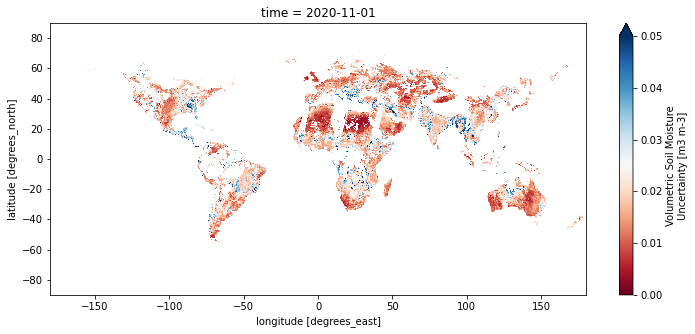

In [7]:
sm_dataset.sel(time="2020-11-01").sm_uncertainty.plot.imshow(cmap='RdBu',  vmin = 0, vmax =0.05, figsize=(12, 5))

---
### Create a spatial subset of Spain

_We will now have a closer look to the time series in Spain and here specifically to the area of Valencia.  
The country border geometry is a useful auxiliary data which is included in the CCI Cate Toolbox environment._

<AxesSubplot:>

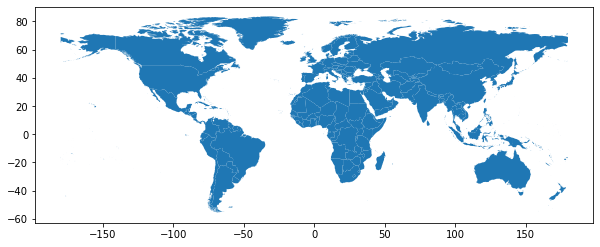

In [8]:
# Open Country Geometries
with open('../resources/countries-50m.geojson') as fp:
    features = json.load(fp)
features

features = gpd.GeoDataFrame.from_features(features)
features.plot(figsize=(10, 10))

In [9]:
desired_country = 'Spain'
valencia = dict(lon=-0.367, lat=39.482) # we will need it later

desired_feature = features.loc[features['sovereignt'] == desired_country]

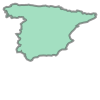

In [10]:
desired_geometry = desired_feature.iloc[0].geometry.geoms[11]
desired_geometry

---
### Investigate the 43 (28) year's time series Soil Moisture for Spain and specifically the area of Valencia

In [14]:
# subset the soil moisture data over Spain
sm_dataset_subset = mask_dataset_by_geometry(sm_dataset, desired_geometry, all_touched=True)
sm_dataset_subset = sm_dataset_subset.sel(time=slice("1992-01-01",None))
sm_dataset_subset

<xarray.Dataset>
Dimensions:         (lat: 32, lon: 51, time: 10593)
Coordinates:
  * lat             (lat) float64 44.12 43.88 43.62 43.38 ... 36.88 36.62 36.38
  * lon             (lon) float64 -9.125 -8.875 -8.625 ... 2.875 3.125 3.375
  * time            (time) datetime64[ns] 1992-01-01 1992-01-02 ... 2020-12-31
Data variables:
    sm              (time, lat, lon) float32 dask.array<chunksize=(7, 32, 37), meta=np.ndarray>
    sm_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(7, 32, 37), meta=np.ndarray>
Attributes: (12/41)
    Conventions:                CF-1.7
    cdm_data_type:              Grid
    comment:                    This dataset was produced with funding of the...
    contact:                    cci_sm_contact@eodc.eu
    creator_email:              cci_sm_contact@eodc.eu
    creator_name:               Department of Geodesy and Geoinformation, Tec...
    ...                         ...
    time_coverage_end:          2020-12-31 00:00:00
    time_coverage_resolution:   P1D
    time_coverage_start:        1978-11-01 00:00:00
    title:                      ESA CCI Surface Soil Moisture COMBINED active...
    tracking_id:                174f51a4-6a06-4352-a712-4d3f77bd8166
    date_modified:              2022-05-19T10:29:38.385409

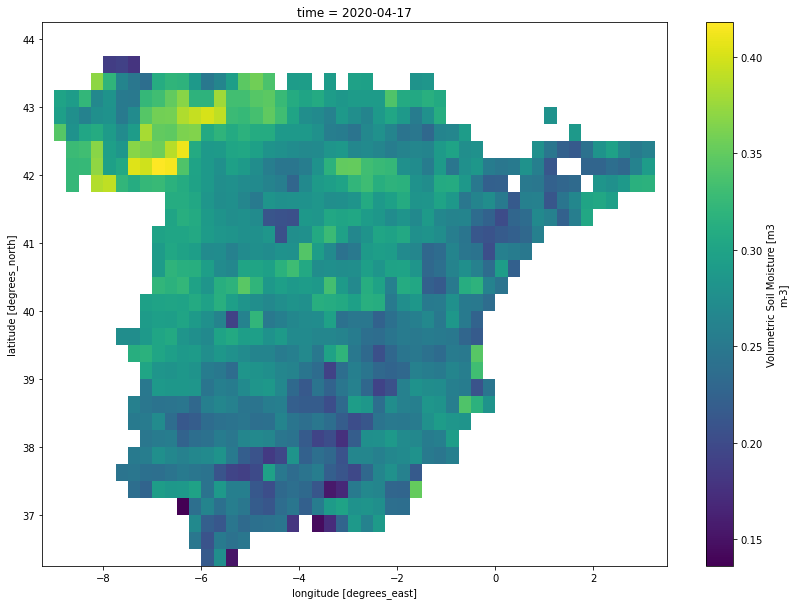

In [12]:
# Let's have a look just at one of the time slices
sm_dataset_subset.sm.sel(time="2020-04-17", method='nearest').plot.imshow(figsize=(14, 10))

_We first compute annual averages from daily data, then aggregate over Spain:_

In [33]:
# calculate the annual average soil moisture for every grid cell of Spain
sm_dataset_subset_annual = sm_dataset_subset.resample(time='1Y').mean()
sm_dataset_subset_annual = cache_dataset(sm_dataset_subset_annual,
                                         f'sm_dataset_subset_annual_{desired_country}.zarr')

In [ ]:
# calculate the annual averages for whole Spain
sm_dataset_subset_annual_country = sm_dataset_subset_annual.mean(("lat","lon"))
# get annual averages for Valencia only
sm_dataset_subset_annual_valencia = sm_dataset_subset_annual.sel(valencia, method="nearest")

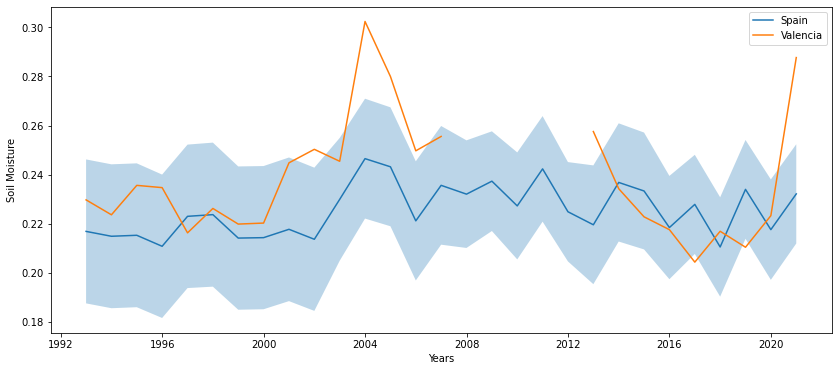

In [35]:
fig, ax = plt.subplots()
#fig.suptitle('Soil Moisture Spain')
fig.set_size_inches(14, 6)
plt.xlabel('Years')
plt.ylabel('Soil Moisture')

x = sm_dataset_subset_annual_country.time.values
y = sm_dataset_subset_annual_country.sm.values
y_unc = sm_dataset_subset_annual_country.sm_uncertainty.values

ax.plot(x, y, label='Spain')
ax.fill_between(x, y - y_unc, y + y_unc, alpha=0.3)

y_val = sm_dataset_subset_annual_valencia.sm.values

ax.plot(x, y_val, label='Valencia')
ax.legend()
#ax.set_yscale('log')

---
### Land Cover ECV

_Tourism and agriculture are important factors in Spain's economy. The landscape of the country mirrors this with its beautiful coasts  
and the large croplands in the Hinterland. However, the climate change is impacting both. The ECVs Land Cover and soil moisture  
allow us to inspect if we can observe already now changes of the land's surface characteristics._  

_We will now add to our notebook the Land Cover dataset included in the Open Data Portal._  

_As with the Soil Moisture, the dataset includes are large number of variables and we drop those not needed for this Masterclass.  
When we inspect the dataset we see that it covers the globe in much high spatial resolution than the Soil Moisture (300m at the equator)  
resulting in a very large grid of 129 600 cells in longitude and 64 800 cells in latitude._  

_The land cover is the long term stable component of the landscape and it is derived from analysing the annual cycle of the colour of the surface and a thorough analysis of potential change. Thus, the dataset have an annual time step. The CCI LC dataset spans from 1992 to 2015 and is derived in harmonised way from multiple satelllite missions._

In [37]:
drop_variables = ['change_count', 'current_pixel_state', 'observation_count', 'processed_flag']  # Not needed
lc_dataset = store.open_data('ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-2015-v2.0.7b.zarr',
                             drop_variables=drop_variables)
lc_dataset = time_to_year(lc_dataset) # this is a helper-function to map the time coordinate to a full year instead of a single day of a year
lc_dataset

,Array,Chunk
Bytes,750.85 GiB,12.81 MiB
Shape,"(24, 64800, 129600)","(1, 2592, 1296)"
Count,60001 Tasks,60000 Chunks
Type,float32,numpy.ndarray


_We create the spatial subset over Spain using the same geometry as for soil moisture. We have a look  
at the land cover 20 years ago, when the MERIS instrument onboard ENVISAT allowed for first time to derive  
a true 300m land cover map._

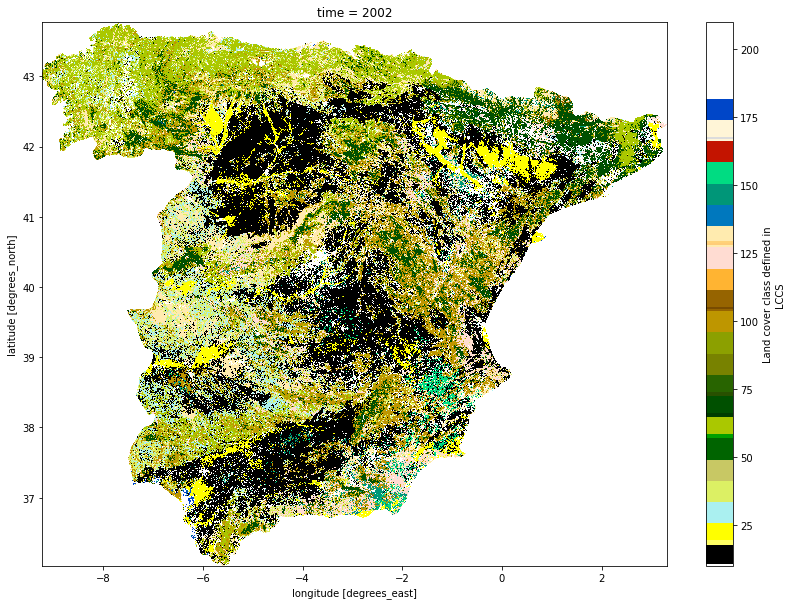

In [38]:
lc_dataset_subset = mask_dataset_by_geometry(lc_dataset, desired_geometry, all_touched=True)
lc_dataset_subset.sel(time=2002).lccs_class.plot.imshow(cmap='land_cover_cci', figsize=(14, 10))

__Now we want to see which are the most frequent land cover classes in Spain.
First, get us the names of the Land Cover Classes__

In [72]:
lc = lc_dataset_subset.sel(time=2015).lccs_class #we pick an arbitrary year, just to get the names
flag_values = [(fv if fv >= 0 else 256 + fv) for fv in lc.attrs['flag_values']]
lccs_class_labels = {
    lccs_class: lccs_class_label 
    for lccs_class, lccs_class_label 
    in zip(flag_values, lc.attrs['flag_meanings'].split(' '))
}
# lccs_class_labels

In [73]:
def lccs_class_counts(lc_dataset_subset, year, lccs_class_labels):
    ds = lc_dataset_subset.sel(time=year)
    ds = ds.chunk(dict(lat=2000, lon=2000))
    ds = cache_dataset(ds, f'lc_dataset_subset_{year}_{desired_country}.zarr')
    lc = ds.lccs_class
    lc_groups = lc.groupby(lc)
    lc_counts = lc_groups.count()
    
    data = [(int(item.lccs_class), int(item)) for item in lc_counts]
    data = sorted(data, key=lambda k: k[1], reverse=True)
    
    lccs_class_data, lccs_class_counts_data = list(zip(*data))    
    lccs_class_label_data = [lccs_class_labels[c] for c in lccs_class_data]
    
    lccs_class = xr.DataArray(
        np.array(lccs_class_data), 
        name='lccs_class', dims="lccs_class"
    )
    lccs_class_label = xr.DataArray(
        np.array(lccs_class_label_data), 
        name='lccs_class_label', dims="lccs_class"
    )
    return xr.DataArray(
        np.array(lccs_class_counts_data),
        name='lccs_class_counts', dims="lccs_class", 
        coords=dict(
            lccs_class=lccs_class,
            lccs_class_label=lccs_class_label
        )
    )

def plot_lc_counts(lc_counts):
    fig, ax = plt.subplots()
    fig.set_size_inches(14, 6)
    ind = np.arange(len(lc_counts.lccs_class))
    ax.set_xticks(ind, labels=lc_counts.lccs_class_label.values, rotation='vertical')
    p1 = ax.bar(ind, lc_counts, label='Counts')    

_Now we count the pixels per class. This translates directly into an area: 1 pixels = 0.3 * 0.3 km².  
In 2002, most area of Spain was "cropland_rainfed_herbaceous_cover". All cropland classes together had a total area of 280 km² (50% of the total area).  
In 2015, the cropland area had decreased by 0.5%. On the other hand, the shrubland and urban areas had increased. This time difference of 13 years is too short in order to conclude on climate change, though._

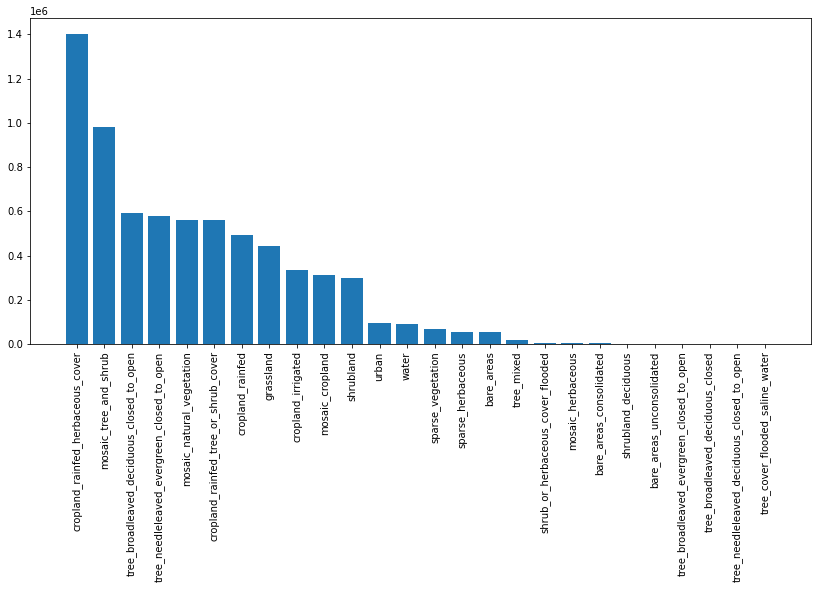

In [70]:
year = 2015
lc_counts = lccs_class_counts(lc_dataset_subset, year, lccs_class_labels)
plot_lc_counts(lc_counts)

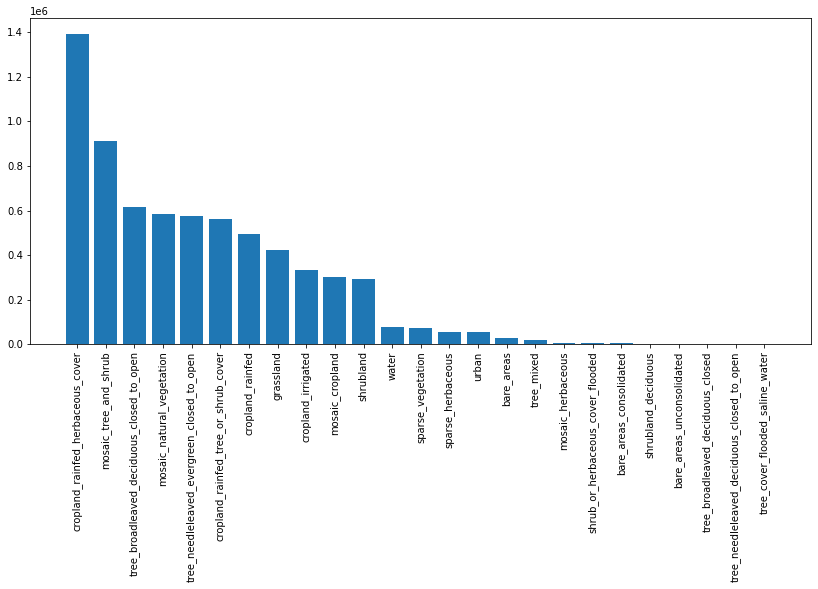

In [71]:
year = 2002
lc_counts = lccs_class_counts(lc_dataset_subset, year, lccs_class_labels)
plot_lc_counts(lc_counts)

_Now we look at the time series of number of pixels (=area) of the 4 most important land cover classes_

In [21]:
def get_lc_counts_timeseries(lc_mask):
    return lc_mask.where(lc_mask).count(dim=('lat', 'lon'))

In [22]:
lcc = lc_dataset_subset.lccs_class

lc_masks_and_names = [
    ((lcc >= 100) & (lcc <= 130), 'Shrubland'),
    ((lcc >= 200) & (lcc <= 240), 'Bare Areas'),
    ((lcc >= 10) & (lcc <= 30), 'Cropland'),
    ((lcc >= 50) & (lcc <= 90), 'Trees'),
]

lc_masks, lc_mask_names = zip(*lc_masks_and_names)
lc_masks, lc_mask_names = list(lc_masks), list(lc_mask_names)

In [23]:
lc_timeseries = [get_lc_counts_timeseries(lc_mask) for lc_mask in lc_masks]
lc_ts = xr.concat(lc_timeseries, "lcc")
lc_ts = lc_ts.assign_coords(lcc=xr.DataArray(lc_mask_names, dims="lcc"))

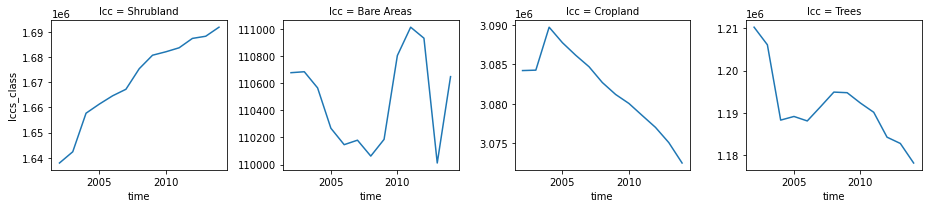

In [24]:
lc_ts[:,10:23].plot.line(x="time", col='lcc', col_wrap=4, sharey=False)

#### ToDo: 
#### (1) plot the time series of annual SM for those pixels which are cropland in 2015 (i.e. those pixels which were cropland all the tinme)
#### (2) plot the time series of annual SM for those pixels which were cropland in 2002 but not in 2015

---

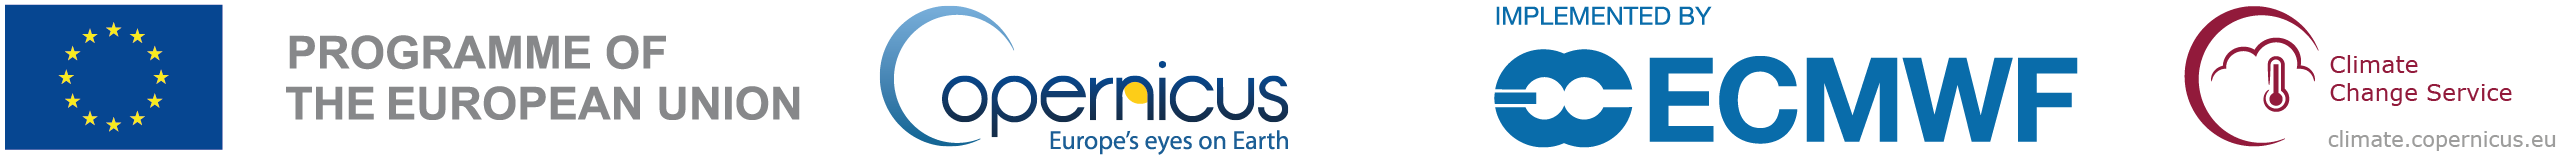

<br>

# Contextualising the Pixel - the Copernicus Climate Change Service (C3S)

Having been captured by the satellite, validated and turned into a Climate Data Record (CDR), the pixel arrives at the [European Centre for Medium-Range Weather Forecasts (ECMWF)](https://www.ecmwf.int/) to be further guided on its journey by the [Copernicus Climate Change Service (C3S)](https://climate.copernicus.eu/). C3S will escort the pixel through its process of integration and assimilation into operational and quality assured products to help it discover its overall climate context. It will ensure the pixel reaches maturity and wisdom before "passing the baton" to other entities who will further shape its development and specialisation. Or it may already accompany it to the doorsteps of the most influential decision makers. C3S helps the pixel achieve its full potential in making the greatest societal impact.

## The pixel arrives at the Climate Data Store (CDS)

Let us look in more detail at this particular stage of the pixel's journey. We begin at the [Climate Data Store (CDS)](https://cds.climate.copernicus.eu/) of C3S. The pixel becomes one of petabytes of quality assured and well documented global and regional datasets of a great number of Essential Climate Variables (ECVs). It may reside as a CDR derived from satellite or in-situ observations, or in gridded "maps without gaps" of observations assimilated into state of the art models ("reanalyses"), and used to provide invaluable climatologies from past decades. It may be a prediction of above/below average conditions for the next months as a seasonal forecast, or projected into future decades with its behaviour hypothesised under different globally defined scenarious (SSP). Whichever the product, the pixel will freely and openly lend its services to whomever wishes to access it. This leads us to our first task...

<div class="alert alert-block alert-success">
<b>ACTIVITY</b>: <br>
    Explore the wealth of quality assured climate data freely available on the <a href="https://cds.climate.copernicus.eu/">Climate Data Store (CDS)</a>! Search using keywords or through the filters on the left panel. Discover the types of data available, including variables over land, sea, atmosphere. Find out their temporal and spatial resolution, units, and any other information available. Can you comment on the variety of data that exists over our pixel?</div>

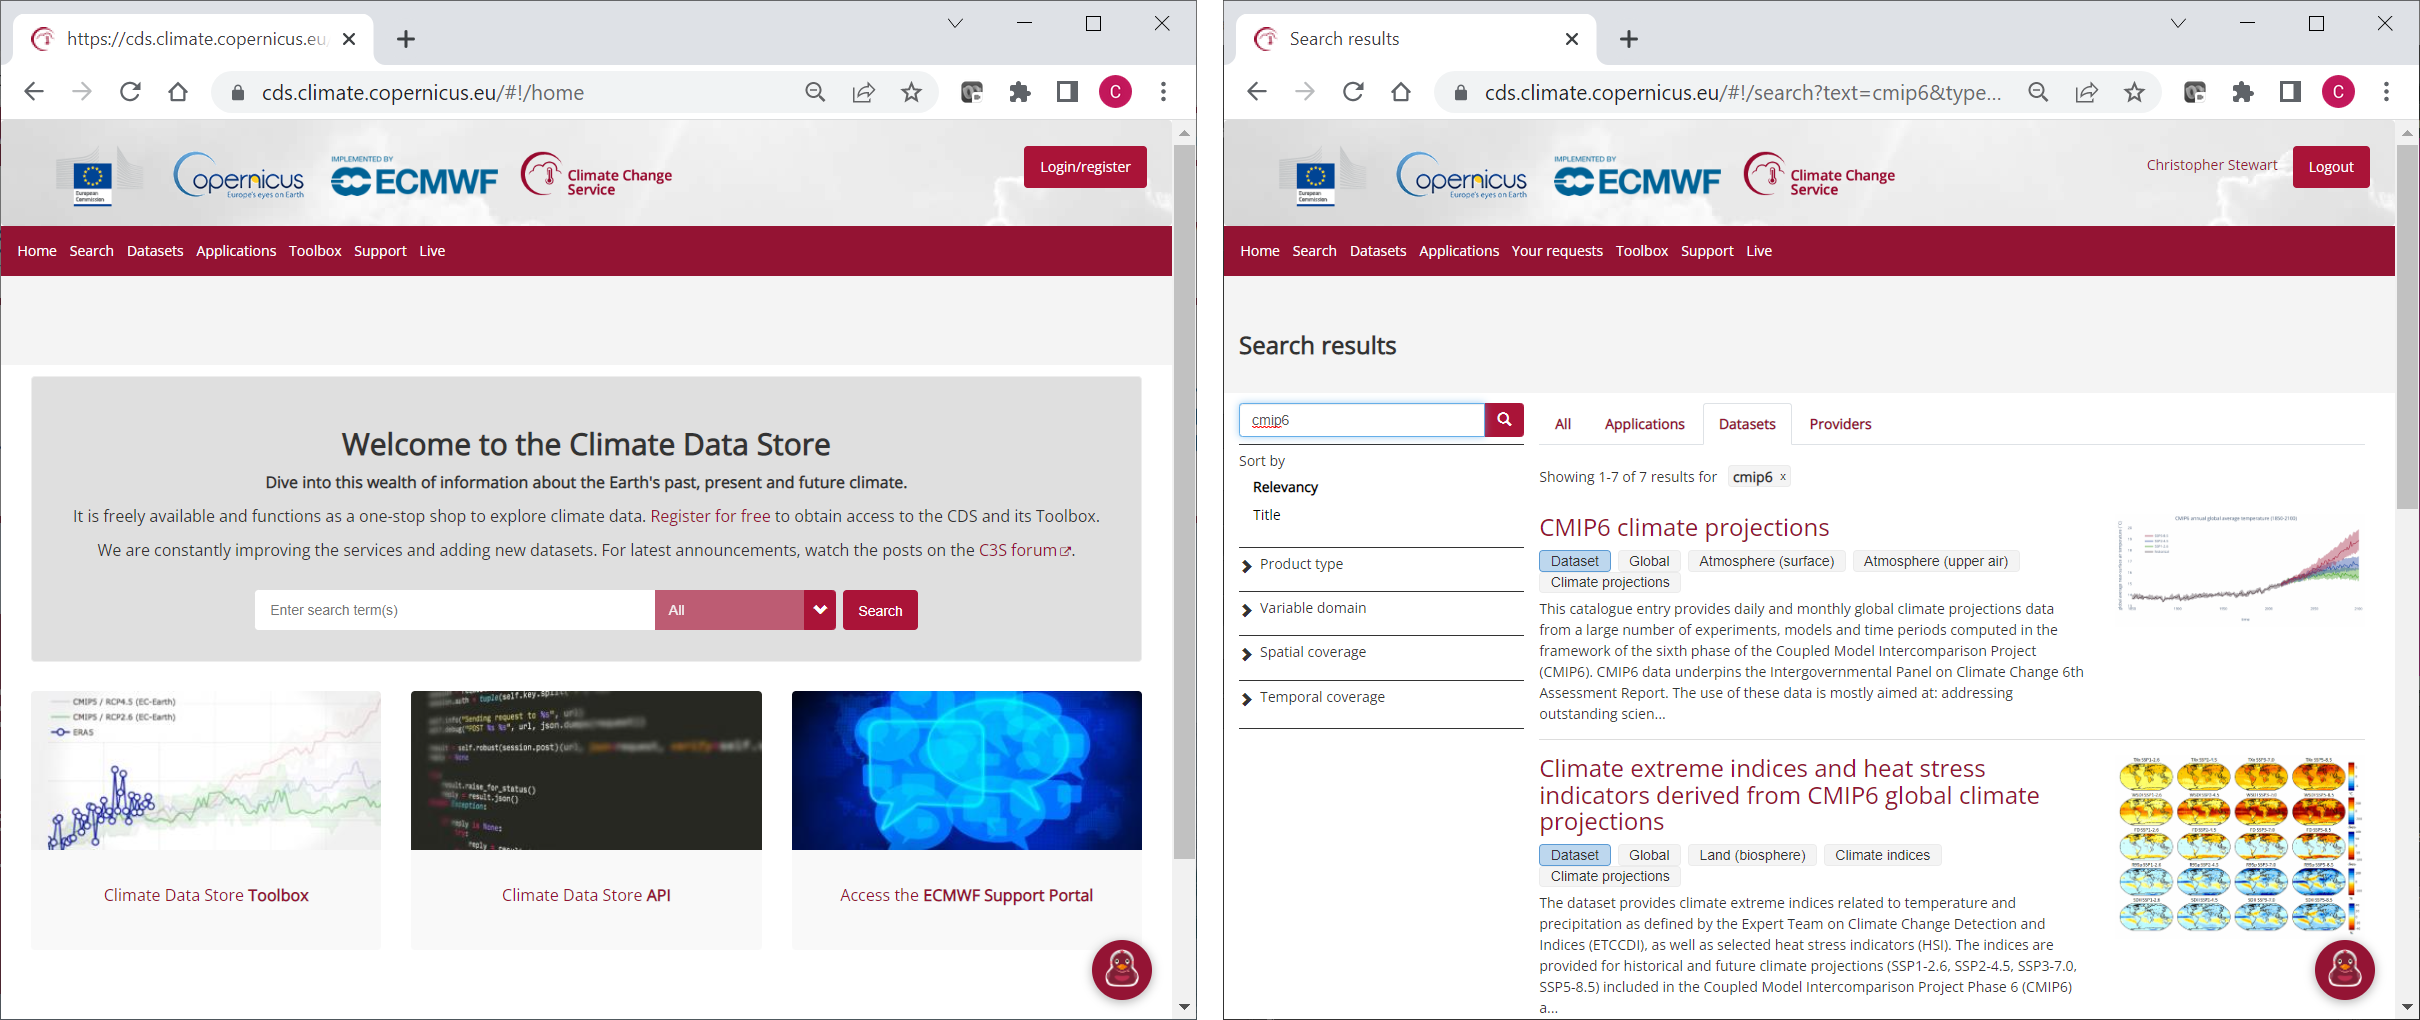

## The pixel is projected in time, according to different scenarios

We will focus now on analysing how our pixel may behave in an extended time period according to various different scenarios. This kind of analysis can aid decision makers in identifying suitable courses of action to mitigate or adapt to climate change. C3S makes available climate projections data from a large number of experiments, models and time periods computed in the framework of the sixth phase of the Coupled Model Intercomparison Project (CMIP6).

<div class="alert alert-block alert-success">
<b>ACTIVITY</b>: <br>
    Discover the <a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=overview">CMIP6 data available through the CDS</a>. Read the information in the "Overview" tab, have a quick glance at the topics and wealth of information present in the "Documentation" tab, then explore the download options in the "Data" tab.</div>

CMIP6 data is freely available to download from the CDS. For this exercise we will use a sample of this data, which can be found here: `../resources/cmip6_processed_data.nc`. 

### Import libraries

Before we can open and analyse this dataset, we will need to import the various libraries we will use:

In [4]:
# Libraries for working with multidimensional arrays
import numpy as np
import pandas as pd
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

### Read and inspect CMIP6 data sample

We will now read our CMIP6 data sample into an Xarray Dataset:

In [5]:
# Create Xarray Dataset
data = xr.open_dataset('../resources/cmip6_processed_data.nc')
data

<xarray.Dataset>
Dimensions:     (year: 251, model: 9, experiment: 4)
Coordinates:
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
    depth       (model) float64 ...
  * model       (model) object 'ACCESS-CM2' 'BCC-CSM2-MR' ... 'NorESM2-MM'
  * experiment  (experiment) object 'historical' 'ssp126' 'ssp245' 'ssp585'
Data variables:
    mrsos       (experiment, model, year) float64 ...

As you can see, this dataset includes three dimensions (**year**, **model** and **experiment**), and one data variable **mrsos**. This data variable is Moisture in Upper Portion of Soil Column, which is the mass of water in all phases in the upper 10cm of the soil layer in units of kg per m-2.

#### Climate Models

Note in the "model" dimension that we have inlcuded a small subset of nine models in this dataset. Climate models are one of the primary means for scientists to understand how the climate has changed in the past and may change in the future. These models simulate the physics, chemistry and biology of the atmosphere, land and oceans in great detail, and require some of the largest supercomputers in the world to generate their climate projections. The models we have included here are from various contributions around the world, inlcuding Europe, North America, Asia and Australasia. See [here for more information about the CMIP6 climate models](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=doc).

In [6]:
models = ['access_cm2', 'bcc_csm2_mr', 'canesm5_canoe', 'cmcc_esm2', 
          'miroc6', 'noresm2_mm', 'cnrm_esm2_1', 'ec_earth3_veg_lr', 
          'mpi_esm1_2_lr']

#### Experiments

The "experiments" refer to different pathways of future climate forcing, typically covering the period up to 2100, but sometimes beyond. In this data sample we include three possible future scenarios: 'SSP 126', 'SSP 245' and 'SSP 585'. Historical experiments typically covering the period from 1850, where modern climate observations exist, are also included for each model. These show how the models perform for the past climate and can be used as a reference period for comparison with scenario runs for the future. See the [full documentation here for more details](https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip6?tab=doc).

In [7]:
experiments = ['historical', 'ssp126', 'ssp245', 'ssp585']

### Plot CMIP6 data sample

We will now visualise this CMIP6 data sample as a plot showing the variation of moisture in the upper portion of the soil column over time, according to different models and experiments. 

Given that we have nine models that each provide competing analyses of how the pixel may be projected in time, a way to visualise this is to view statistical properties of this ensemble of data. We will calculate upper and lower quantiles, together with the mean of all models, to have an idea of the consensus and uncertainties of these models for each scenario.

#### Calculate quantiles and median of model ensemble

In [8]:
data_90 = data['mrsos'].quantile(0.9, dim='model') # 90th quantile (near to upper limit)
data_10 = data['mrsos'].quantile(0.1, dim='model') # 10th quantile (near to lower limit)
data_50 = data['mrsos'].mean(dim='model') # Mean

/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


> **Note:** The warning message is due to the presence of NaN (Not a Number) data given that the historical and scenario datasets represent only parts (historical and future respectively) of the entire time series. As these two datasets have been merged, NaN values will exist (e.g. there will be no data for the historical experiment for the future period).

#### Create plot

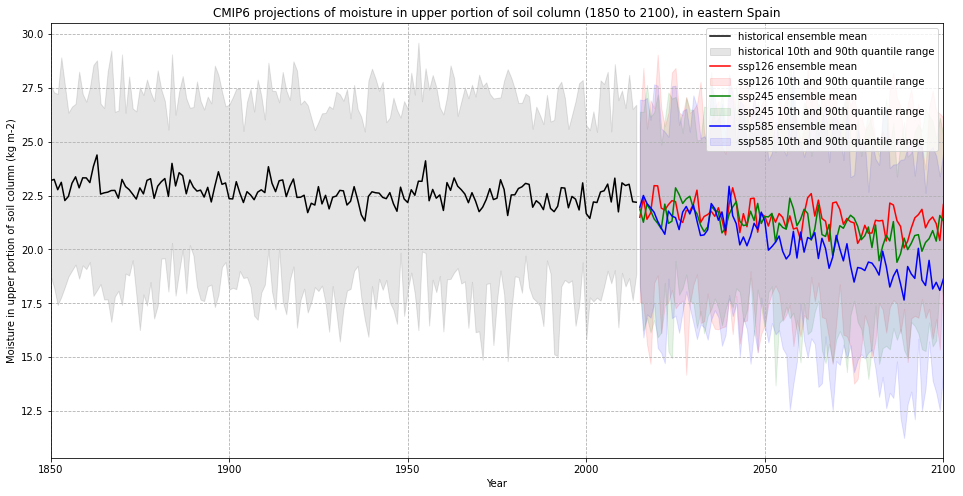

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (16, 8))

colours = ['black','red','green','blue']
for i in np.arange(len(experiments)):
    ax.plot(data_50.year, data_50[i,:], color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} ensemble mean')
    ax.fill_between(data_50.year, data_90[i,:], data_10[i,:], alpha=0.1, color=f'{colours[i]}', 
            label=f'{data_50.experiment[i].values} 10th and 90th quantile range')

ax.set_xlim(1850,2100)
ax.set_title('CMIP6 projections of moisture in upper portion of soil column (1850 to 2100), in eastern Spain')
ax.set_ylabel('Moisture in upper portion of soil column (kg m-2)')
ax.set_xlabel('Year')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

fig.savefig(f'./CMIP6_soil_moisture.png')

Notice how the models suggest, for the period 1850 to present, a very gradual decrease in the moisture in the upper portion of the soil column in the location of our pixel. In future decades on the other hand, even the most "optimistic" scenarios suggest an increasing decline, while the most "pessimistic" (SSP585) outlines a progressively sharper decline over time.

## Further evolutions of the pixel

The analysis of the pixel we have carried out so far has benefitted from significant global modelling and collaboration activities to provide data in support to climate change related decision making. We have seen how this data can be turned into information in the form of graphical charts. C3S goes even further to provide ready to use information products which can be even more easily generated with the help of online applications, requiring no programming. These are [available on the CDS](https://cds.climate.copernicus.eu/cdsapp#!/search?type=application).

<div class="alert alert-block alert-success">
<b>ACTIVITY</b>: <br>
    Explore the <a href="https://cds.climate.copernicus.eu/cdsapp#!/search?type=application">applications available on the CDS</a>. In particular, experiment with the <a href="https://cds.climate.copernicus.eu/cdsapp#!/software/app-satellite-soil-moisture?tab=app">Satellite Soil Moisture</a> application. In the 1992 to 2019 climatology for our pixel, in which month is the satellite derived soil moisture at its lowest level?</div>

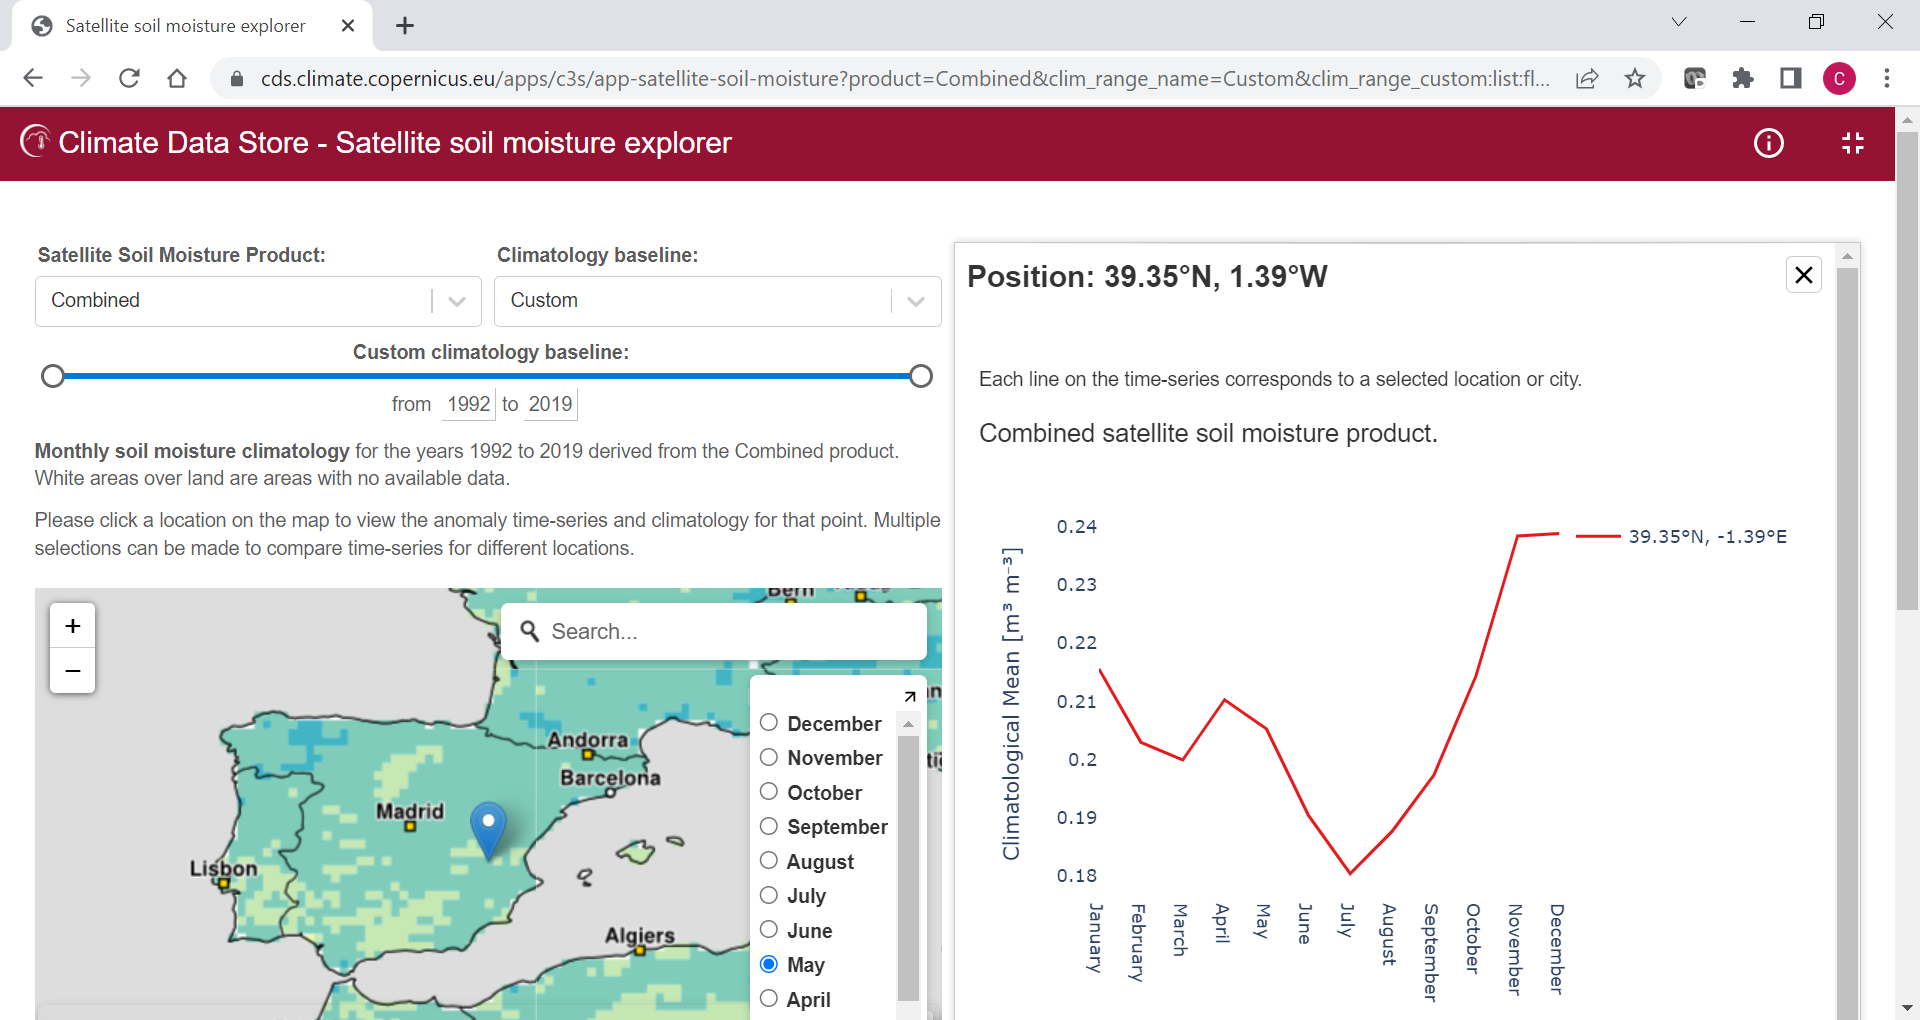

## Closing the loop, ...and a new pixel.

The pixel has reached the end of its journey. Having accumulated a wealth of knowledge, it imparts wisdom to decision makers. These decision makers in turn will evaluate the information utility and additional needs that need to be addressed. These are ultimately transmitted back as requirements for new missions, instruments and services that will all contribute to shape the journey of a new generation of pixel!

<br>